In [1]:
import sys
sys.path.insert(0, '..')  # bring the project folder to path
from parameters import *
from utils import *

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA

In [39]:
# load data from each run for all conditions

conditions=['0bk_faces', '2bk_faces','0bk_tools', '2bk_tools','0bk_places', '2bk_places','0bk_body', '2bk_body']

X_run0 = []
X_run1 = []
y_one_run=[]

for idx,condition in enumerate(conditions):
    for subject in subjects:
        run0=get_condition_bold(subject,'wm', condition, run=0)
        run1=get_condition_bold(subject,'wm', condition, run=1)
        X_run0.append(run0)
        X_run1.append(run1)
        y_one_run.append(1*idx//2) # add labels 

Uncomment below to split training and test data differently:
1. Within one run - compare accross subjects
2. Mixed run0 and run1 
3. Across runs - compare within subjects

In [77]:
# # 1) split training and test data (within one run)
# x_train, x_test, y_train, y_test = train_test_split(X_run0, y_one_run,test_size=0.2, random_state=2020)

# 2) use to split training and test data by mixing runs
X = np.vstack((X_run0,X_run1))
y = np.hstack((y_one_run,y_one_run))
x_train, x_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=2020)

# # 3) use to trian on run0 and test on run1 (or vice versa)
# x_train = X_run1
# x_test = X_run0
# y_train = y_one_run
# y_test = y_one_run

In [78]:
# Run PCA

# normalize data to standard scale
scaler = StandardScaler()
scaler.fit(x_train) # fit only to traning data
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

# run PCA on run0
comps = 100 # number of components
pca = PCA(comps)
pca.fit(x_train)

# project data into PC space
x_train_pcs = pca.transform(x_train)
x_test_pcs = pca.transform(x_test)

# project back into origional space
x_train_inv = pca.inverse_transform(x_train_pcs)
x_test_inv = pca.inverse_transform(x_test_pcs)

In [81]:
# Run logistic regression 
log_reg = LogisticRegression(C=1, penalty='l1', multi_class='multinomial', solver='saga',max_iter=5000)
log_reg.fit(x_train_pcs,y_train)

print(f'Training data accuracy: {np.sum(log_reg.predict(x_train_pcs) == y_train)/len(y_train)}')
print(f'Test data accuracy: {np.sum(log_reg.predict(x_test_pcs) == y_test)/len(y_test)}')

Training data accuracy: 0.994007835906891
Test data accuracy: 0.943778801843318


In [ ]:
# run logistic regression while varying the number of PCs

comps = [6,10,50,100,150,200,250,360] # number of components to test
train_acc = np.array([])
test_acc = np.array([])

for comp in comps:
    # run pca for n components
    pca = PCA(comp)
    pca.fit(x_train)
    
    # transform data into PC space
    x_train_pcs = pca.transform(x_train)
    x_test_pcs = pca.transform(x_test)
    
    # Run logistic regression
    log_reg = LogisticRegression(C=1, penalty='l1', solver='saga', multi_class='multinomial', max_iter=5000)
    log_reg.fit(x_train_pcs,y_train)
    
    train_acc = np.append(train_acc,np.sum(log_reg.predict(x_train_pcs) == y_train)/len(y_train))
    test_acc = np.append(test_acc,np.sum(log_reg.predict(x_test_pcs) == y_test)/len(y_test))
    
    print(f'Training acc {comp} components: {np.sum(log_reg.predict(x_train_pcs) == y_train)/len(y_train)}')
    print(f'Test data acc {comp} components: {np.sum(log_reg.predict(x_test_pcs) == y_test)/len(y_test)}')

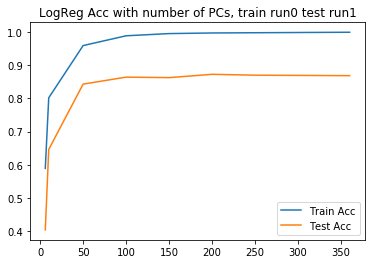

In [72]:
# plot regression accuracy based on numbr of PCs
plt.figure()
plt.plot(comps,train_acc, label='Train Acc')
plt.plot(comps, test_acc, label='Test Acc')
plt.title('LogReg Acc with number of PCs, train run0 test run1')
plt.legend(loc='best')
# plt.savefig('log_reg_PCs_acrossRuns')

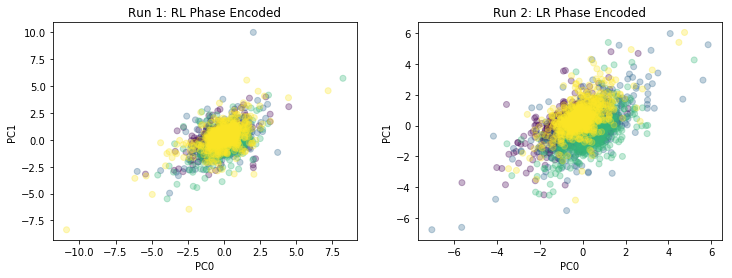

In [73]:
# modify which PCs are plotted
pc1=0
pc2=1

colors=['b','o']

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(x_train[:,pc1],x_train[:,pc2],c=y_train, alpha=0.3)
plt.xlabel('PC{}'.format(pc1))
plt.ylabel('PC{}'.format(pc2))
plt.title('Run 1: RL Phase Encoded')

plt.subplot(122)
plt.scatter(x_test[:,pc1],x_test[:,pc2],c=y_test, alpha=0.3)
plt.xlabel('PC{}'.format(pc1))
plt.ylabel('PC{}'.format(pc2))
plt.title('Run 2: LR Phase Encoded')

plt.savefig('PCARun1vsRun2')